In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import torch
from os import listdir
from os.path import isfile, join
from sklearn import preprocessing
import torchvision.transforms as transforms
import torchvision.models as models
from torch import nn
import torch.utils.data
import statistics 

In [2]:
#Get link to directory
path_to_train_info = os.path.join(os.getenv('DATASETS'), 'ArtRecognision\\train_info.csv')
path_to_train_set = os.path.join(os.getenv('DATASETS'), 'ArtRecognision\\train_2\\')
path_to_transformed_train_set = os.path.join(os.getenv('DATASETS'), 'ArtRecognision\\transformed_images\\')

In [3]:
#Load datasets
train_set = pd.read_csv(path_to_train_info)
train_set

,filename,artist,title,style,genre,date
0,102257.jpg,5b39c876740bfc1cfaf544721c43cac3,Uriel,Color Field Painting,abstract,1955.0
1,75232.jpg,5b39c876740bfc1cfaf544721c43cac3,Vir Heroicus Sublimis,Color Field Painting,abstract,1950.0
2,29855.jpg,96e5bc98488ed589b9bf17ad9fd09371,Night March of a Hundred Demons (left half),Yamato-e,mythological painting,NaN
3,62252.jpg,5b39c876740bfc1cfaf544721c43cac3,"Who’s Afraid of Red, Yellow and Blue II",Color Field Painting,abstract,NaN
4,63861.jpg,5b39c876740bfc1cfaf544721c43cac3,Black Fire I,Color Field Painting,abstract,1963.0
...,...,...,...,...,...,...
79428,23862.jpg,67959e4e5df05b3d9db7c97fd9a0b0f6,Number 547,Abstract Expressionism,NaN,1954.0
79429,25525.jpg,2d72f2000c42051e7c350a39bdce9bc1,Number 13A (Arabesque),Action painting,abstract,1948.0
79430,47038.jpg,f920b951670e3d8dc3c759f12ced7a3e,St. Francis of Assisi,Baroque,religious painting,NaN
79431,9021.jpg,e4183fd3d19c2bca8b7c56d19af92252,Thebe's Revenge,NaN,marina,1982.0


In [4]:
#Get list of images
onlyfiles = [f for f in listdir(path_to_train_set) if isfile(join(path_to_train_set, f))]

In [5]:
#Leave data only for the downloaded images
filtered_train_set = train_set[train_set.filename.isin(onlyfiles)]
final_train_dataset = filtered_train_set[['filename', 'style', 'genre']].dropna()

In [6]:
def lowest_size(name_list, directory_path):
   # name_list = img_column.tolist()
    first_img = cv2.imread(os.path.join(directory_path, str(name_list[0])))
    min_value = min(first_img.shape[:-1])
    for name in name_list[1:]:
        img=cv2.imread(os.path.join(directory_path, name))
        if min(img.shape[:-1]) < min_value:
            min_value = min(img.shape[:-1])

    return min_value

In [7]:
#get dict where keys are image filenames, values - image minimum size and minimum size to maximum size ratio
def get_min_and_ratio_dict(img_column, directory_path):
    name_list = img_column.tolist()
    min_dict = {}
    for name in name_list:
        img=cv2.imread(os.path.join(directory_path, name)) 
        min_dict[name] = min(img.shape[:-1]), min(img.shape[:-1])/max(img.shape[:-1])
    return min_dict

In [8]:
#fuction to crop images with square
def crop_image(image, crop_size):
    height, width, _ = image.shape
    cropped_img = image[(height-crop_size)//2 : (height+crop_size)//2, (width-crop_size)//2 : (width+crop_size)//2].copy()
    return cropped_img

In [9]:
def transform_image(file_list, path_to_train_set, path_to_transformed_train_set, crop_size, img_size):
    for name in final_train_dataset['filename']:
        try:
            img=cv2.imread(os.path.join(path_to_train_set, name))
            c_image = crop_image(img, crop_size)
            r_image=cv2.resize(c_image,(img_size,img_size),interpolation=cv2.INTER_AREA)
            t_image = torch.Tensor(r_image)
            new_name = name.split(".", 1)[0] + ".pt"
            torch.save(t_image, path_to_transformed_train_set + new_name)

        except:
            continue 

In [10]:
image_min_and_ratio_dict = get_min_and_ratio_dict(final_train_dataset['filename'], path_to_train_set)

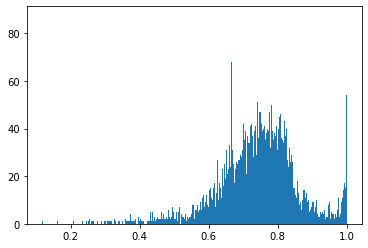

In [11]:
#ratio histogram
plt.hist([d[1] for d in image_min_and_ratio_dict.values()], bins=750)
plt.show()

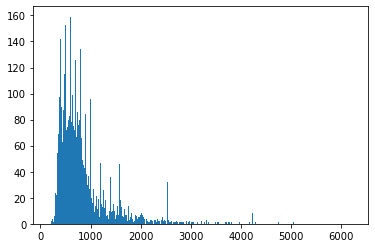

In [12]:
#min size histogram
plt.hist([d[0] for d in image_min_and_ratio_dict.values()], bins=750)
plt.show()

In [13]:
#calculate mean and std of the ratio of images
image_ratio_standart_deviation = statistics.pstdev([d[1] for d in image_min_and_ratio_dict.values()]) 
image_ratio_mean = statistics.mean([d[1] for d in image_min_and_ratio_dict.values()])

In [14]:
image_ratio_standart_deviation

0.11438913251732333

In [15]:
image_ratio_mean

0.7435620707364642

In [16]:
#calculate mean and std of the minimum sizes of images
min_size_standart_deviation = statistics.pstdev([d[0] for d in image_min_and_ratio_dict.values()]) 
min_size_mean = statistics.mean([d[0] for d in image_min_and_ratio_dict.values()]) 

In [17]:
min_size_standart_deviation

559.2099676383365

In [18]:
min_size_mean

855.2864176774349

In [19]:
#leave only those whose image ratio lay to the right of the lower border
filtered_dict = {key:val for key, val in image_min_and_ratio_dict.items() if val[1] >= (image_ratio_mean - 1.5*image_ratio_standart_deviation)}
len(filtered_dict)

7797

In [20]:
#leave only those whose minimum size lay in the borders of 2 standart deviations (~95%)
cleaned_dict = {key:val for key, val in filtered_dict.items() if val[0] >= (min_size_mean - min_size_standart_deviation) and val[0] <= (min_size_mean + min_size_standart_deviation)}
len(cleaned_dict)

6821

In [21]:
#sort our cleaned dictionary by values
sorted_dict = {k: v for k, v in sorted(cleaned_dict.items(), key=lambda item: item[1])}

In [ ]:
#because we have sorted dictionary, we know the minimum size of each image, 
#so at each iteration we take keys of the 50 elements (in other words - filenames), 
#load these images, crop them by minimum element of subset (in our case subset size is 50), then resize to 224, turn to tensor and save  
for i in range(0, len(sorted_dict), 50): 
    dict_slice = list(sorted_dict.keys())[i:i+50]
    crop_size = lowest_size(dict_slice, path_to_train_set)
    transform_image(dict_slice, path_to_train_set, path_to_transformed_train_set, crop_size, 224)    

In [47]:
discriminator = models.resnet18(pretrained=True)

In [ ]:
discriminator.fc = nn.Sequential(nn.Linear(1000, 512),
                                 nn.Tanh(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 1))

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        n_features = 100

        def block(in_channels, out_channels, kernel_size, stride, padding):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)]
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append([nn.ConvTranspose2d(in_channels, out_channels, 1, 1, 1)])
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append([nn.ConvTranspose2d(in_channels, out_channels, 1, 1, 1)])
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append([nn.ConvTranspose2d(in_channels, out_channels, 1, 1, 1)])
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers     
                
        self.linear1= nn.Linear(n_features, 256)
        self.linear2= nn.Linear(256, 6272)
        
        self.deconv1 = nn.Sequential(*block(128, 128, 4, 2, 1))      
        self.deconv2 = nn.Sequential(*block(128, 128, 4, 2, 1))        
        self.deconv3 = nn.Sequential(*block(256, 128, 4, 2, 1))
        self.deconv4 = nn.Sequential(*block(384, 128, 4, 2, 1))
        self.deconv5 = nn.Sequential(*block(512, 128, 4, 2, 1))
        self.deconv6 = nn.Sequential(*block(128, 64, 1, 1, 1))
        self.deconv7 = nn.Sequential(*block(64, 32, 1, 1, 1))
        self.deconv8 = nn.ConvTranspose2d(32, 3, 1, 1, 1)
        
        
        def forward(self, x):
            
            linear1 = F.LeakyReLU(self.linear1(x))
            linear2 = F.LeakyReLU(self.linear2(linear1))
            hidden1 = linear2.view(-1, 128*7*7)
            deconv1 = self.deconv1(hidden1)
            deconv2 = self.deconv2(deconv1)
            c2_dense = F.LeakyReLU(torch.cat([deconv1, deconv2], 1))
            deconv3 = self.deconv3(c2_dense)
            c3_dense = F.LeakyReLU(torch.cat([deconv1, deconv2, deconv3], 1))                  
            deconv4 = self.deconv4(c3_dense)         
            c4_dense = F.LeakyReLU(torch.cat([deconv1, deconv2, deconv3, deconv4], 1))   
            deconv5 = self.deconv5(c4_dense)
            c5_dense = F.LeakyReLU(torch.cat([deconv1, deconv2, deconv3, deconv4, deconv5], 1))
            deconv6 = self.deconv6(c5_dense)
            deconv7 = self.deconv7(deconv6)
            deconv8 = F.tanh(self.deconv8(deconv7))
            
            return deconv8

In [ ]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = discriminator.to(device)

In [ ]:
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.002, amsgrad=False)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.002, amsgrad=False)

In [ ]:
train_images = torch.load(path_to_transformed_train_set)
train_dataset = torch.utils.data.TensorDataset(train_images)
train_dataloader = torch.utils.data.DataLoader(train_tensor, batch_size=250, shuffle=True)

In [ ]:
num_epochs = 500
generator.train()
discriminator.train()

for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy_with_logits(real_pred, label_real) +
            F.binary_cross_entropy_with_logits(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))